 *Обучение модели проводим следующими наборами:

ADABoost на семплированных и несемплированных
---
остальные классификаторы на несемплированных данных с перевзешиванием(если возможно) и на семплированных*

In [6]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (GradientBoostingClassifier,
                              AdaBoostClassifier,
                              StackingClassifier)
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     cross_val_score)
from sklearn.metrics import  (classification_report,
                             accuracy_score,
                             roc_curve,
                             auc,
                             roc_auc_score,
                            confusion_matrix)


Файл записан в df
Информация о данных:
Размер: (284807, 31)
Колонки: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Пропущенные значения: 31
Значения и их кол-во в целевой переменной: Class
0    284315
1       492
Name: count, dtype: int64



<Axes: >

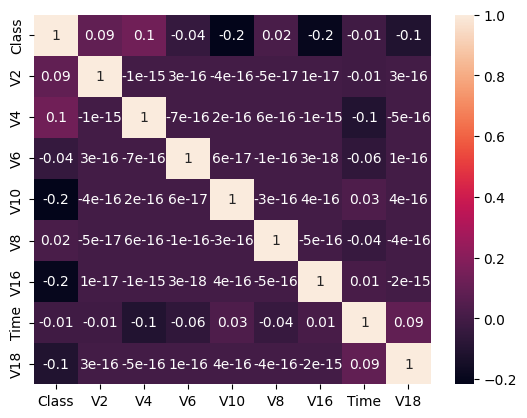

In [7]:
try:
  df = pd.read_csv('creditcard.csv')
  print("Файл записан в df")
except FileNotFoundError:
  print("Файл не найден или неправильный формат расширения")
except Exception as e:
  print(f"Ошибка загрузки: {e}")

print("Информация о данных:")
print(f"Размер: {df.shape}")
print(f"Колонки: {list(df.columns)}")
print(f"\nПропущенные значения: {df.isnull().sum().count()}")
print(f"Значения и их кол-во в целевой переменной: {df['Class'].value_counts()}")
print()
sns.heatmap(df[['Class', 'V2', 'V4','V6','V10', 'V8', 'V16', 'Time', 'V18']].corr(), annot=True, fmt=".1g")

In [8]:
# удалим строки с пропусками и столбец со временем
df_process = df.dropna().drop('Time', axis=1)

# делим на х, у и сокращаем кол-во строк до кол-ва 1 в у
target = 'Class'
X_beforeRUS = df_process.drop(target, axis=1)
y_beforeRUS = df_process[target]

xtrain,xtest, ytrain, ytest = train_test_split(X_beforeRUS, y_beforeRUS, test_size=0.3, stratify=y_beforeRUS)

X, y = RandomUnderSampler().fit_resample(X_beforeRUS, y_beforeRUS)
X_rustrain, X_rustest, y_rustrain, y_rustest = train_test_split(X, y, test_size=0.3, stratify=y)
print(f"Распределение классов в y_train: {Counter(y_rustrain)}")
print(f"Распределение классов в y_test: {Counter(y_rustest)}")

Распределение классов в y_train: Counter({0: 344, 1: 344})
Распределение классов в y_test: Counter({1: 148, 0: 148})


Accuracy на тестовых данных: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.15      0.86      0.25       148

    accuracy                           0.99     85443
   macro avg       0.57      0.93      0.62     85443
weighted avg       1.00      0.99      0.99     85443



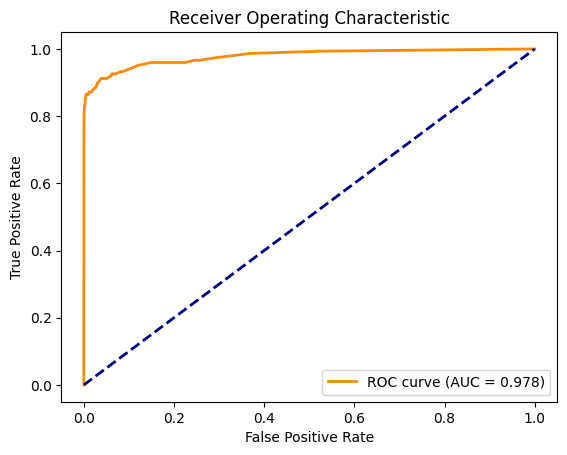

<Axes: >

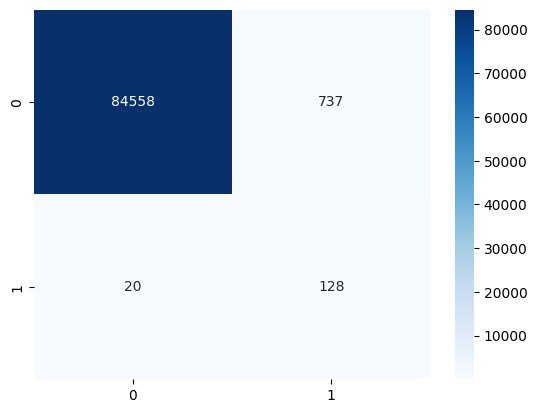

In [7]:
# обучим адабуст на не семплированных данных
clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',max_depth=2) ,learning_rate=0.1, n_estimators=100)

clf.fit(xtrain, ytrain)

ypred = clf.predict(xtest)


accuracy = accuracy_score(ytest, ypred)
report = classification_report(ytest, ypred)

print(f'Accuracy на тестовых данных: {accuracy:.2f}')
print('Classification Report:')
print(report)


y_proba = clf.predict_proba(xtest)[:, 1]
fpr, tpr, thresholds = roc_curve(ytest, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

sns.heatmap(confusion_matrix(ytest, ypred), annot=True, fmt='d', cmap='Blues')

На несемплированных данных AdaBoost автоматически уходит в переобучение, решить можно присвоив естиматору например дерево решений и закрыть глаза на предсказание первого класса


Лучшие параметры: {'learning_rate': 0.3, 'n_estimators': 45}
Лучшая точность (CV): 0.9418914630276103
Accuracy на тестовых данных: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       148
           1       0.96      0.88      0.92       148

    accuracy                           0.92       296
   macro avg       0.93      0.92      0.92       296
weighted avg       0.93      0.92      0.92       296



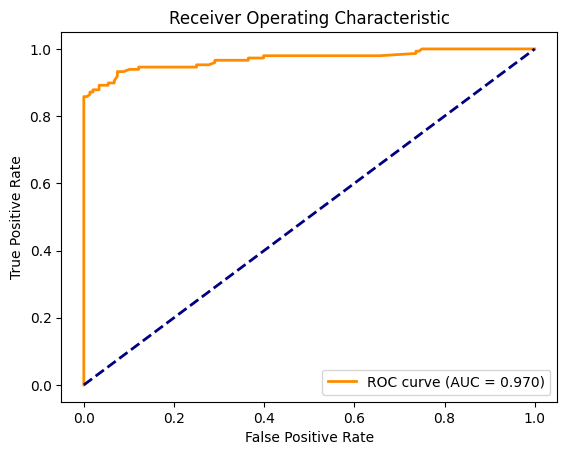

<Axes: >

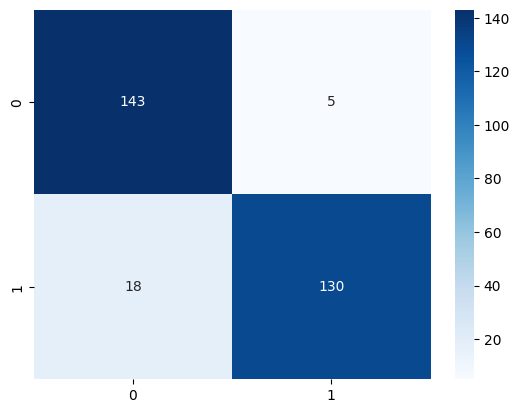

In [8]:
 # обучим адабуст и на семплированных данных
param_grid_ada = {
    'learning_rate': [0.2, 0.1, 0.3, 0.5],
    'n_estimators': [35, 45, 55, 65,100]
    }

clf = AdaBoostClassifier()

grid_search = GridSearchCV(
    estimator = clf,
    param_grid = param_grid_ada,
    scoring = 'accuracy',
    cv = 5
)

grid_search.fit(X_rustrain, y_rustrain)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая точность (CV): {grid_search.best_score_}")

best_clf = grid_search.best_estimator_

ypred = best_clf.predict(X_rustest)


accuracy = accuracy_score(y_rustest, ypred)
report = classification_report(y_rustest, ypred)

print(f'Accuracy на тестовых данных: {accuracy:.2f}')
print('Classification Report:')
print(report)


y_proba = best_clf.predict_proba(X_rustest)[:, 1]
fpr, tpr, thresholds = roc_curve(y_rustest, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

sns.heatmap(confusion_matrix(y_rustest, ypred), annot=True, fmt='d', cmap='Blues')

Лучшие параметры: {'learning_rate': 0.5, 'n_estimators': 100}
Лучшая точность (CV): 0.9433407383899292
Accuracy на тестовых данных: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       148
           1       0.96      0.89      0.92       148

    accuracy                           0.92       296
   macro avg       0.92      0.92      0.92       296
weighted avg       0.92      0.92      0.92       296



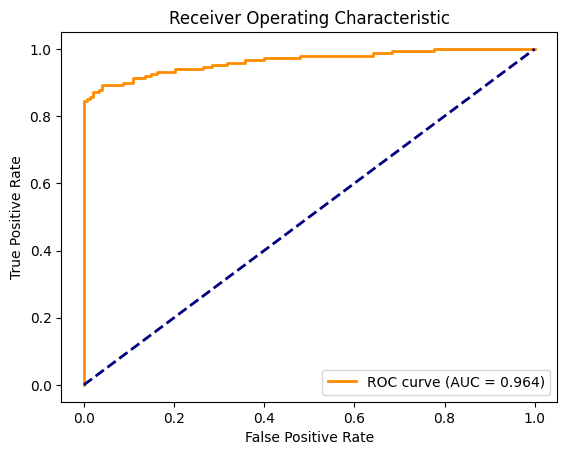

<Axes: >

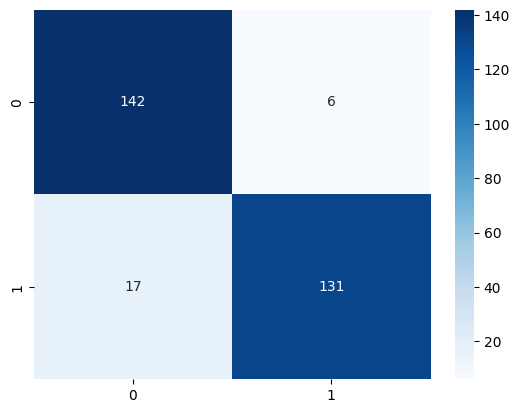

In [9]:
# градиентный бустинг на семплированных

param_grid_grad = {
    'learning_rate': [0.1, 0.25, 0.5, 0.75],
    'n_estimators': [10, 25, 50, 75, 100],
    'loss': ['log_loss', 'exponential']
}

clf = GradientBoostingClassifier()

grid_search = GridSearchCV(
    estimator = clf,
    param_grid = param_grid_ada,
    scoring = 'accuracy',
    cv = 5
)

grid_search.fit(X_rustrain, y_rustrain)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая точность (CV): {grid_search.best_score_}")

best_clf = grid_search.best_estimator_

ypred = best_clf.predict(X_rustest)


accuracy = accuracy_score(y_rustest, ypred)
report = classification_report(y_rustest, ypred)

print(f'Accuracy на тестовых данных: {accuracy:.2f}')
print('Classification Report:')
print(report)


y_proba = best_clf.predict_proba(X_rustest)[:, 1]
fpr, tpr, thresholds = roc_curve(y_rustest, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

sns.heatmap(confusion_matrix(y_rustest, ypred), annot=True, fmt='d', cmap='Blues')

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.34      0.27      0.30       148

    accuracy                           1.00     85443
   macro avg       0.67      0.63      0.65     85443
weighted avg       1.00      1.00      1.00     85443



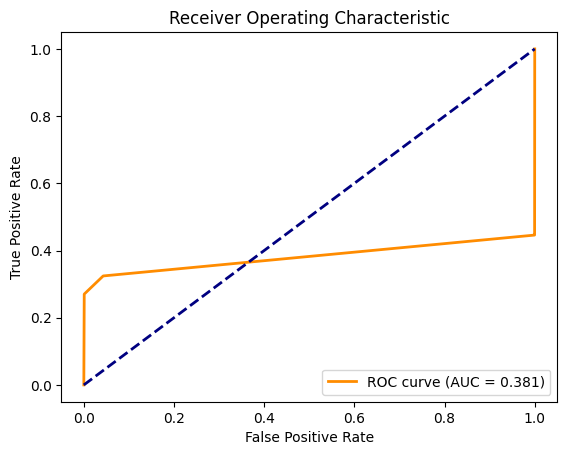

<Axes: >

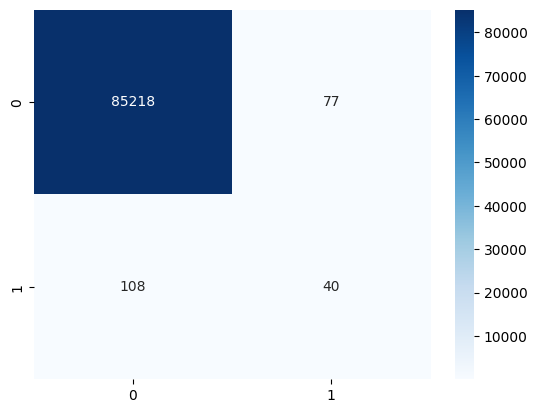

In [10]:
# градиентный бустинг на несемплированных данных

clf = GradientBoostingClassifier(learning_rate=0.5, n_estimators=100)
clf.fit(xtrain, ytrain)

y_pred = clf.predict(xtest)

accuracy = accuracy_score(ytest, y_pred)
report = classification_report(ytest, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print("Classification Report:")
print(report)


y_proba = clf.predict_proba(xtest)[:, 1]
fpr, tpr, thresholds = roc_curve(ytest, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

sns.heatmap(confusion_matrix(ytest, y_pred), annot=True, fmt='d', cmap='Blues')

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

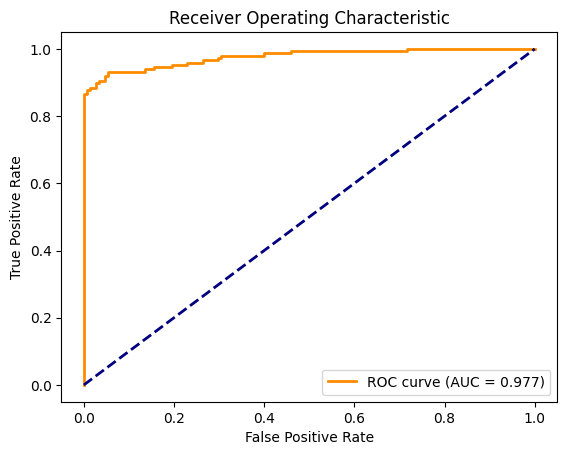

<Axes: >

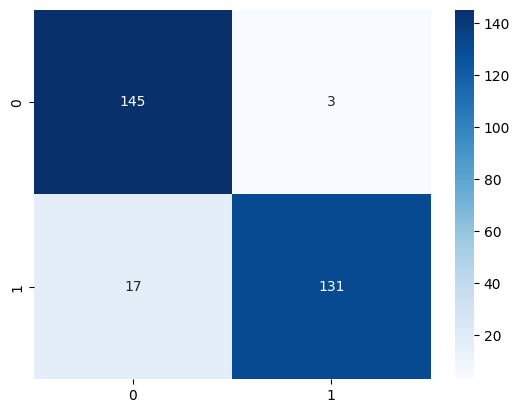

In [11]:
# легкий бустинг на семплированных

param_grid_lgbm = {
    'num_leaves': [10, 30, 40, 50],
    'learning_rate': [0.05, 0.1, 0.25, 0.5, 1]
}

clf = lgb.LGBMClassifier()

grid_search = GridSearchCV(
    estimator = clf,
    param_grid = param_grid_lgbm,
    scoring = 'accuracy',
    cv =5
)

grid_search.fit(X_rustrain, y_rustrain)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая точность (CV): {grid_search.best_score_}")

best_clf = grid_search.best_estimator_

ypred = best_clf.predict(X_rustest)


accuracy = accuracy_score(y_rustest, ypred)
report = classification_report(y_rustest, ypred)

print(f'Accuracy на тестовых данных: {accuracy:.2f}')
print('Classification Report:')
print(report)


y_proba = best_clf.predict_proba(X_rustest)[:, 1]
fpr, tpr, thresholds = roc_curve(y_rustest, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

sns.heatmap(confusion_matrix(y_rustest, ypred), annot=True, fmt='d', cmap='Blues')

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further split

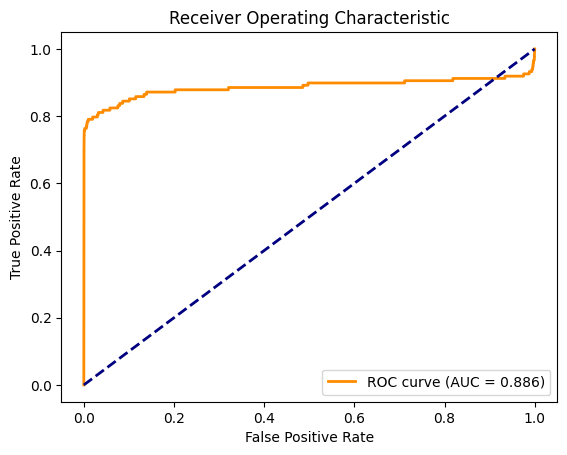

<Axes: >

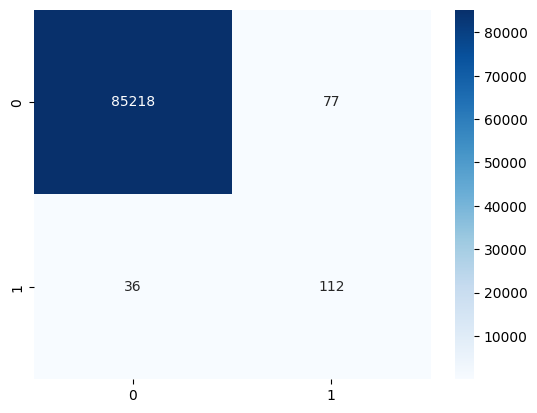

In [12]:
# LGBM на несемплировааных с class_weight 'balanced'
param_grid_lgbm = {
    'num_leaves': [10, 30, 40, 50]
}

clf = lgb.LGBMClassifier(learning_rate=0.05, class_weight='balanced')
grid_search.fit(xtrain, ytrain)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая точность (CV): {grid_search.best_score_}")

best_clf = grid_search.best_estimator_

y_pred = best_clf.predict(xtest)

accuracy = accuracy_score(ytest, y_pred)
report = classification_report(ytest, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print("Classification Report:")
print(report)


y_proba = best_clf.predict_proba(xtest)[:, 1]
fpr, tpr, thresholds = roc_curve(ytest, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

sns.heatmap(confusion_matrix(ytest, y_pred), annot=True, fmt='d', cmap='Blues')

Лучшие параметры: {'criterion': 'entropy', 'max_depth': 5}
Лучшая точность (CV): 0.9287633555485032
Accuracy на тестовых данных: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       148
           1       0.91      0.87      0.89       148

    accuracy                           0.90       296
   macro avg       0.90      0.90      0.90       296
weighted avg       0.90      0.90      0.90       296



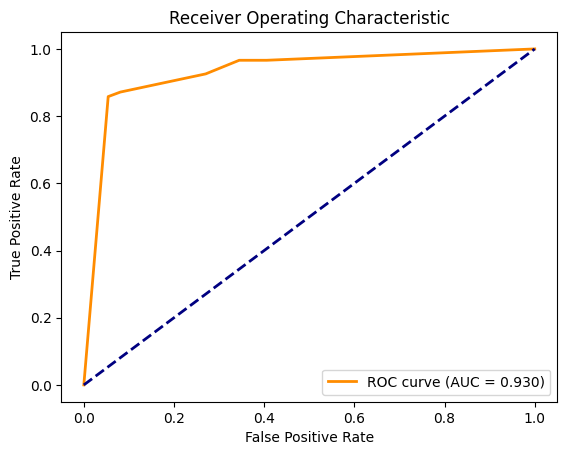

<Axes: >

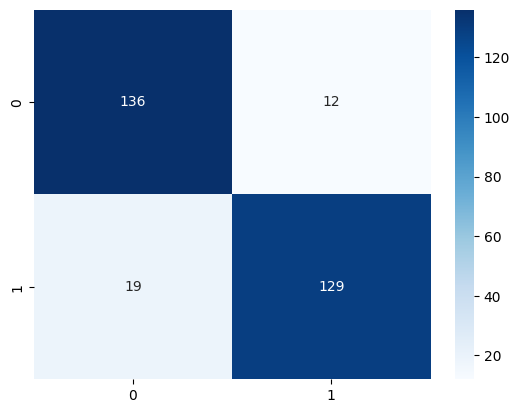

In [13]:
# решающее дерево на сэмплированных

param_grid_tree = {
    'max_depth': [1, 2, 3, 5],
    'criterion': ['gini', 'entropy'],

}

clf = DecisionTreeClassifier()

grid_search = GridSearchCV(
    estimator = clf,
    param_grid = param_grid_tree,
    cv = 5,
    scoring = 'accuracy'
)

grid_search.fit(X_rustrain, y_rustrain)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая точность (CV): {grid_search.best_score_}")

best_clf = grid_search.best_estimator_

ypred = best_clf.predict(X_rustest)


accuracy = accuracy_score(y_rustest, ypred)
report = classification_report(y_rustest, ypred)

print(f'Accuracy на тестовых данных: {accuracy:.2f}')
print('Classification Report:')
print(report)


y_proba = best_clf.predict_proba(X_rustest)[:, 1]
fpr, tpr, thresholds = roc_curve(y_rustest, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

sns.heatmap(confusion_matrix(y_rustest, ypred), annot=True, fmt='d', cmap='Blues')

Лучшие параметры: {'criterion': 'gini', 'max_depth': 5}
Лучшая точность (CV): 0.9993930703649818
Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.93      0.76      0.84       148

    accuracy                           1.00     85443
   macro avg       0.97      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443



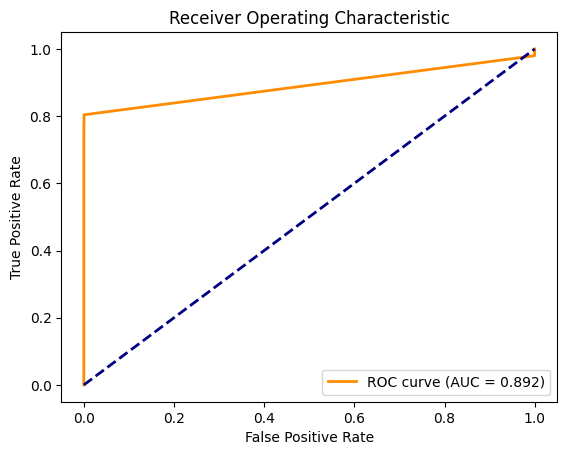

<Axes: >

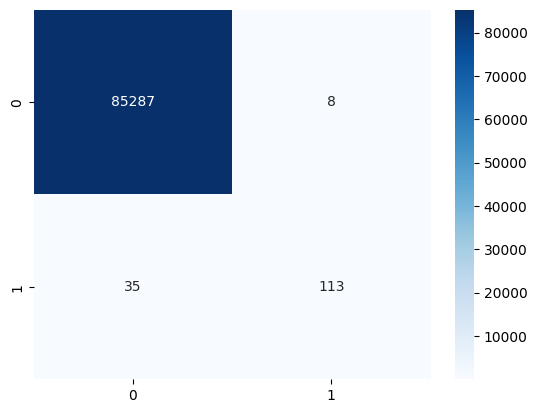

In [15]:
# решающее дерево на несэмплированных
param_grid_lgbm = {
    'max_depth': [1,2,3],
    'criterion': ['gini', 'entropy']
}

clf = DecisionTreeClassifier(class_weight='balanced')
grid_search.fit(xtrain, ytrain)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая точность (CV): {grid_search.best_score_}")

best_clf = grid_search.best_estimator_

y_pred = best_clf.predict(xtest)

accuracy = accuracy_score(ytest, y_pred)
report = classification_report(ytest, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print("Classification Report:")
print(report)


y_proba = best_clf.predict_proba(xtest)[:, 1]
fpr, tpr, thresholds = roc_curve(ytest, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

sns.heatmap(confusion_matrix(ytest, y_pred), annot=True, fmt='d', cmap='Blues')

In [21]:
from xgboost import XGBClassifier
clfs = [lgb.LGBMClassifier(learning_rate=0.05,num_leaves=40, class_weight='balanced'),
        DecisionTreeClassifier(class_weight='balanced',max_depth=2),
        GradientBoostingClassifier(learning_rate=0.5, n_estimators=100),
        AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',max_depth=2),
                            learning_rate=0.1,
                            n_estimators=100)
        ]

for classifier in clfs:
  base_classifiers = [
      ('clf', classifier)
  ]

  meta_classifier = XGBClassifier()

  stack_model = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier, cv=5)

  stack_model.fit(xtrain, ytrain)

  # Предсказание и оценка
  y_pred = stack_model.predict(xtest)

  # Оценка модели
  accuracy = accuracy_score(ytest, y_pred)
  report = classification_report(ytest, y_pred)
  print(classifier)
  print(f'Accuracy на тестовых данных: {accuracy:.2f}')
  print('Classification Report:')
  print(report)


[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 275, number of negative: 159216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 159491, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LGBMClassifier(class_weight='balanced', learning_rate=0.05, num_leaves=40)
Accuracy на тестовых данных: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.00      0.00      0.00       148

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


DecisionTreeClassifier(class_weight='balanced', max_depth=2)
Accuracy на тестовых данных: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.00      0.00      0.00       148

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

GradientBoostingClassifier(learning_rate=0.5)
Accuracy на тестовых данных: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.34      0.27      0.30       148

    accuracy                           1.00     85443
   macro avg       0.67      0.63      0.65     85443
weighted avg       1.00      1.00      1.00     85443

AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                

In [9]:
clfs = [lgb.LGBMClassifier(learning_rate=0.05,
                           num_leaves=40,
                           class_weight='balanced'),
        DecisionTreeClassifier(class_weight='balanced',
                               max_depth=2),
        GradientBoostingClassifier(learning_rate=0.5,
                                   n_estimators=100),
        AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',max_depth=2),
                            learning_rate=0.1,
                            n_estimators=100)
        ]

for classifier in clfs:
  base_classifiers = [
      ('clf', classifier)
  ]

  meta_classifier = XGBClassifier()

  stack_model = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier, cv=5)

  stack_model.fit(X_rustrain, y_rustrain)

  # Предсказание и оценка
  y_pred = stack_model.predict(X_rustest)

  # Оценка модели
  accuracy = accuracy_score(y_rustest, y_pred)
  report = classification_report(y_rustest, y_pred)
  print(classifier)
  print(f'Accuracy на тестовых данных: {accuracy:.2f}')
  print('Classification Report:')
  print(report)

[LightGBM] [Info] Number of positive: 344, number of negative: 344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6655
[LightGBM] [Info] Number of data points in the train set: 688, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit